<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:13:18] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


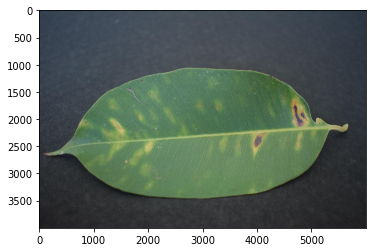

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

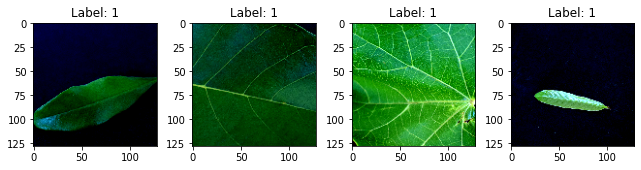

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:13:26] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:13:28] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2533132590648148 samples/sec                   batch loss = 1.5386345386505127 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2637237906103602 samples/sec                   batch loss = 1.5828548669815063 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.2600539209313388 samples/sec                   batch loss = 0.738932192325592 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2598636358038469 samples/sec                   batch loss = 0.725330114364624 | accuracy = 0.5875


Epoch[1] Batch[25] Speed: 1.2610177726279763 samples/sec                   batch loss = 0.5453863143920898 | accuracy = 0.6


Epoch[1] Batch[30] Speed: 1.2562475365076093 samples/sec                   batch loss = 0.36193105578422546 | accuracy = 0.6166666666666667


Epoch[1] Batch[35] Speed: 1.2604764249541218 samples/sec                   batch loss = 1.9209767580032349 | accuracy = 0.6071428571428571


Epoch[1] Batch[40] Speed: 1.2590612103597258 samples/sec                   batch loss = 0.5692299604415894 | accuracy = 0.60625


Epoch[1] Batch[45] Speed: 1.264606613814223 samples/sec                   batch loss = 0.24684025347232819 | accuracy = 0.6111111111111112


Epoch[1] Batch[50] Speed: 1.261400141393489 samples/sec                   batch loss = 0.629127025604248 | accuracy = 0.62


Epoch[1] Batch[55] Speed: 1.2665431720560554 samples/sec                   batch loss = 1.0533723831176758 | accuracy = 0.6136363636363636


Epoch[1] Batch[60] Speed: 1.2619538633441234 samples/sec                   batch loss = 0.3934342861175537 | accuracy = 0.625


Epoch[1] Batch[65] Speed: 1.2326895931096646 samples/sec                   batch loss = 0.9213744401931763 | accuracy = 0.6230769230769231


Epoch[1] Batch[70] Speed: 1.2280700239044922 samples/sec                   batch loss = 0.8310350775718689 | accuracy = 0.6285714285714286


Epoch[1] Batch[75] Speed: 1.2355870410041407 samples/sec                   batch loss = 0.21194645762443542 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.2439959449976539 samples/sec                   batch loss = 0.8225839734077454 | accuracy = 0.634375


Epoch[1] Batch[85] Speed: 1.2273387297891691 samples/sec                   batch loss = 0.34120699763298035 | accuracy = 0.6323529411764706


Epoch[1] Batch[90] Speed: 1.2364764478848138 samples/sec                   batch loss = 0.2835838198661804 | accuracy = 0.6333333333333333


Epoch[1] Batch[95] Speed: 1.2495629714056573 samples/sec                   batch loss = 0.6977362632751465 | accuracy = 0.631578947368421


Epoch[1] Batch[100] Speed: 1.2484806081689928 samples/sec                   batch loss = 1.1044933795928955 | accuracy = 0.63


Epoch[1] Batch[105] Speed: 1.245041715076499 samples/sec                   batch loss = 0.5826788544654846 | accuracy = 0.6357142857142857


Epoch[1] Batch[110] Speed: 1.2467926547416452 samples/sec                   batch loss = 0.491106778383255 | accuracy = 0.6363636363636364


Epoch[1] Batch[115] Speed: 1.2455724726459414 samples/sec                   batch loss = 0.4034982919692993 | accuracy = 0.6413043478260869


Epoch[1] Batch[120] Speed: 1.245860687285642 samples/sec                   batch loss = 1.4570425748825073 | accuracy = 0.6375


Epoch[1] Batch[125] Speed: 1.2521880355149004 samples/sec                   batch loss = 0.5932414531707764 | accuracy = 0.636


Epoch[1] Batch[130] Speed: 1.2455992905884778 samples/sec                   batch loss = 0.3966319262981415 | accuracy = 0.6461538461538462


Epoch[1] Batch[135] Speed: 1.2488873901738384 samples/sec                   batch loss = 0.605758786201477 | accuracy = 0.6481481481481481


Epoch[1] Batch[140] Speed: 1.2475825749677643 samples/sec                   batch loss = 0.8066520690917969 | accuracy = 0.6464285714285715


Epoch[1] Batch[145] Speed: 1.2467446613307842 samples/sec                   batch loss = 0.2827479839324951 | accuracy = 0.65


Epoch[1] Batch[150] Speed: 1.2431834749794854 samples/sec                   batch loss = 1.0338313579559326 | accuracy = 0.6516666666666666


Epoch[1] Batch[155] Speed: 1.2451140644721366 samples/sec                   batch loss = 0.507785439491272 | accuracy = 0.65


Epoch[1] Batch[160] Speed: 1.245809897812528 samples/sec                   batch loss = 1.4965872764587402 | accuracy = 0.646875


Epoch[1] Batch[165] Speed: 1.2510902995628064 samples/sec                   batch loss = 0.6430525779724121 | accuracy = 0.6454545454545455


Epoch[1] Batch[170] Speed: 1.2454158419428267 samples/sec                   batch loss = 0.36664968729019165 | accuracy = 0.6426470588235295


Epoch[1] Batch[175] Speed: 1.246863910461802 samples/sec                   batch loss = 0.5074465870857239 | accuracy = 0.6457142857142857


Epoch[1] Batch[180] Speed: 1.2498735205668483 samples/sec                   batch loss = 0.6635885834693909 | accuracy = 0.6513888888888889


Epoch[1] Batch[185] Speed: 1.2448328452971753 samples/sec                   batch loss = 0.5506044626235962 | accuracy = 0.65


Epoch[1] Batch[190] Speed: 1.2460076207717647 samples/sec                   batch loss = 0.866503894329071 | accuracy = 0.6447368421052632


Epoch[1] Batch[195] Speed: 1.2498598330452517 samples/sec                   batch loss = 0.48031991720199585 | accuracy = 0.6448717948717949


Epoch[1] Batch[200] Speed: 1.2398036203543619 samples/sec                   batch loss = 0.4421161115169525 | accuracy = 0.645


Epoch[1] Batch[205] Speed: 1.2474635593572578 samples/sec                   batch loss = 0.5268436074256897 | accuracy = 0.6439024390243903


Epoch[1] Batch[210] Speed: 1.2488648926765666 samples/sec                   batch loss = 0.27687525749206543 | accuracy = 0.6511904761904762


Epoch[1] Batch[215] Speed: 1.2502793474277158 samples/sec                   batch loss = 0.9924047589302063 | accuracy = 0.6534883720930232


Epoch[1] Batch[220] Speed: 1.2491373342440595 samples/sec                   batch loss = 0.35237058997154236 | accuracy = 0.6556818181818181


Epoch[1] Batch[225] Speed: 1.2512606790595342 samples/sec                   batch loss = 0.26709872484207153 | accuracy = 0.6566666666666666


Epoch[1] Batch[230] Speed: 1.2454397870612668 samples/sec                   batch loss = 0.3610680103302002 | accuracy = 0.657608695652174


Epoch[1] Batch[235] Speed: 1.2438069744964655 samples/sec                   batch loss = 0.592195987701416 | accuracy = 0.6627659574468086


Epoch[1] Batch[240] Speed: 1.244585543958185 samples/sec                   batch loss = 0.6467209458351135 | accuracy = 0.665625


Epoch[1] Batch[245] Speed: 1.2477726945452055 samples/sec                   batch loss = 0.4228907823562622 | accuracy = 0.6683673469387755


Epoch[1] Batch[250] Speed: 1.25056079591203 samples/sec                   batch loss = 1.0014538764953613 | accuracy = 0.668


Epoch[1] Batch[255] Speed: 1.2456195435242168 samples/sec                   batch loss = 0.4754466414451599 | accuracy = 0.6705882352941176


Epoch[1] Batch[260] Speed: 1.2475786785399152 samples/sec                   batch loss = 0.6642587184906006 | accuracy = 0.6682692307692307


Epoch[1] Batch[265] Speed: 1.2523770372979162 samples/sec                   batch loss = 0.43486711382865906 | accuracy = 0.6716981132075471


Epoch[1] Batch[270] Speed: 1.2468316636913872 samples/sec                   batch loss = 0.6695386171340942 | accuracy = 0.6694444444444444


Epoch[1] Batch[275] Speed: 1.2472421004990466 samples/sec                   batch loss = 0.33106735348701477 | accuracy = 0.67


Epoch[1] Batch[280] Speed: 1.2473418770852114 samples/sec                   batch loss = 0.5367100834846497 | accuracy = 0.6705357142857142


Epoch[1] Batch[285] Speed: 1.2471453065026228 samples/sec                   batch loss = 0.5170782208442688 | accuracy = 0.6710526315789473


Epoch[1] Batch[290] Speed: 1.2317110299378207 samples/sec                   batch loss = 0.3292686343193054 | accuracy = 0.6741379310344827


Epoch[1] Batch[295] Speed: 1.236808789847167 samples/sec                   batch loss = 0.6384284496307373 | accuracy = 0.6771186440677966


Epoch[1] Batch[300] Speed: 1.2402937011973778 samples/sec                   batch loss = 0.2677326202392578 | accuracy = 0.6783333333333333


Epoch[1] Batch[305] Speed: 1.2346667469308694 samples/sec                   batch loss = 0.8533584475517273 | accuracy = 0.6811475409836065


Epoch[1] Batch[310] Speed: 1.2362029421649123 samples/sec                   batch loss = 0.22985729575157166 | accuracy = 0.6814516129032258


Epoch[1] Batch[315] Speed: 1.2406827786469832 samples/sec                   batch loss = 0.4661453366279602 | accuracy = 0.6817460317460318


Epoch[1] Batch[320] Speed: 1.2398902980590798 samples/sec                   batch loss = 0.3627248704433441 | accuracy = 0.6828125


Epoch[1] Batch[325] Speed: 1.2320961881886112 samples/sec                   batch loss = 0.6126773953437805 | accuracy = 0.6823076923076923


Epoch[1] Batch[330] Speed: 1.2359782696939554 samples/sec                   batch loss = 0.13371087610721588 | accuracy = 0.6840909090909091


Epoch[1] Batch[335] Speed: 1.2391780862187105 samples/sec                   batch loss = 0.5125165581703186 | accuracy = 0.6843283582089552


Epoch[1] Batch[340] Speed: 1.2433494039566266 samples/sec                   batch loss = 0.3105792999267578 | accuracy = 0.6845588235294118


Epoch[1] Batch[345] Speed: 1.2394912780152674 samples/sec                   batch loss = 0.1603221297264099 | accuracy = 0.6876811594202898


Epoch[1] Batch[350] Speed: 1.2416925642245868 samples/sec                   batch loss = 0.35604462027549744 | accuracy = 0.69


Epoch[1] Batch[355] Speed: 1.2322725657513285 samples/sec                   batch loss = 2.0760409832000732 | accuracy = 0.6866197183098591


Epoch[1] Batch[360] Speed: 1.2365986626007908 samples/sec                   batch loss = 0.1691858470439911 | accuracy = 0.6881944444444444


Epoch[1] Batch[365] Speed: 1.2437911142844498 samples/sec                   batch loss = 0.6296993494033813 | accuracy = 0.6883561643835616


Epoch[1] Batch[370] Speed: 1.2317057851984745 samples/sec                   batch loss = 0.36368951201438904 | accuracy = 0.6891891891891891


Epoch[1] Batch[375] Speed: 1.2377908156764554 samples/sec                   batch loss = 0.5804673433303833 | accuracy = 0.6913333333333334


Epoch[1] Batch[380] Speed: 1.2375767943138736 samples/sec                   batch loss = 0.42158910632133484 | accuracy = 0.6907894736842105


Epoch[1] Batch[385] Speed: 1.2483244527369033 samples/sec                   batch loss = 0.5731661915779114 | accuracy = 0.6915584415584416


Epoch[1] Batch[390] Speed: 1.2467528143910147 samples/sec                   batch loss = 0.5981742739677429 | accuracy = 0.6929487179487179


Epoch[1] Batch[395] Speed: 1.2382691615755494 samples/sec                   batch loss = 1.0935965776443481 | accuracy = 0.6930379746835443


Epoch[1] Batch[400] Speed: 1.2385616864361266 samples/sec                   batch loss = 0.4187401235103607 | accuracy = 0.694375


Epoch[1] Batch[405] Speed: 1.2443149917963934 samples/sec                   batch loss = 0.6516002416610718 | accuracy = 0.6950617283950618


Epoch[1] Batch[410] Speed: 1.2428591155064033 samples/sec                   batch loss = 0.20847421884536743 | accuracy = 0.6957317073170731


Epoch[1] Batch[415] Speed: 1.2393699557749265 samples/sec                   batch loss = 0.9595130681991577 | accuracy = 0.6951807228915663


Epoch[1] Batch[420] Speed: 1.2367877283221407 samples/sec                   batch loss = 0.42642778158187866 | accuracy = 0.6964285714285714


Epoch[1] Batch[425] Speed: 1.237274423594771 samples/sec                   batch loss = 1.0451222658157349 | accuracy = 0.6958823529411765


Epoch[1] Batch[430] Speed: 1.2382489641782588 samples/sec                   batch loss = 0.33920207619667053 | accuracy = 0.6982558139534883


Epoch[1] Batch[435] Speed: 1.2367174372554766 samples/sec                   batch loss = 0.5365084409713745 | accuracy = 0.696551724137931


Epoch[1] Batch[440] Speed: 1.2349325738587198 samples/sec                   batch loss = 0.3479466736316681 | accuracy = 0.6960227272727273


Epoch[1] Batch[445] Speed: 1.2370853002726536 samples/sec                   batch loss = 0.540908932685852 | accuracy = 0.6943820224719102


Epoch[1] Batch[450] Speed: 1.2334972877672348 samples/sec                   batch loss = 0.9071077108383179 | accuracy = 0.695


Epoch[1] Batch[455] Speed: 1.2378135552304015 samples/sec                   batch loss = 0.695242702960968 | accuracy = 0.6961538461538461


Epoch[1] Batch[460] Speed: 1.2411383882186804 samples/sec                   batch loss = 0.2937038540840149 | accuracy = 0.6978260869565217


Epoch[1] Batch[465] Speed: 1.2420393020387186 samples/sec                   batch loss = 0.2873157858848572 | accuracy = 0.6967741935483871


Epoch[1] Batch[470] Speed: 1.2382177097761924 samples/sec                   batch loss = 1.5479930639266968 | accuracy = 0.6968085106382979


Epoch[1] Batch[475] Speed: 1.236729379791555 samples/sec                   batch loss = 0.21211524307727814 | accuracy = 0.6978947368421052


Epoch[1] Batch[480] Speed: 1.2428115165075795 samples/sec                   batch loss = 0.569341242313385 | accuracy = 0.6979166666666666


Epoch[1] Batch[485] Speed: 1.244087914809587 samples/sec                   batch loss = 0.884539008140564 | accuracy = 0.6989690721649484


Epoch[1] Batch[490] Speed: 1.2409929679943033 samples/sec                   batch loss = 0.37007617950439453 | accuracy = 0.7005102040816327


Epoch[1] Batch[495] Speed: 1.2402700452359703 samples/sec                   batch loss = 1.4352096319198608 | accuracy = 0.7


Epoch[1] Batch[500] Speed: 1.2388813363825604 samples/sec                   batch loss = 0.168489009141922 | accuracy = 0.6995


Epoch[1] Batch[505] Speed: 1.2393850625328457 samples/sec                   batch loss = 0.411521852016449 | accuracy = 0.7


Epoch[1] Batch[510] Speed: 1.239797298670396 samples/sec                   batch loss = 0.6353192925453186 | accuracy = 0.6985294117647058


Epoch[1] Batch[515] Speed: 1.239216620135397 samples/sec                   batch loss = 1.2686899900436401 | accuracy = 0.6975728155339805


Epoch[1] Batch[520] Speed: 1.2354746700024617 samples/sec                   batch loss = 0.31207001209259033 | accuracy = 0.6990384615384615


Epoch[1] Batch[525] Speed: 1.2388575513070343 samples/sec                   batch loss = 0.40135204792022705 | accuracy = 0.7


Epoch[1] Batch[530] Speed: 1.2414036108049633 samples/sec                   batch loss = 0.4544541537761688 | accuracy = 0.6990566037735849


Epoch[1] Batch[535] Speed: 1.2488456495927291 samples/sec                   batch loss = 0.25651636719703674 | accuracy = 0.7


Epoch[1] Batch[540] Speed: 1.2412219468179089 samples/sec                   batch loss = 0.12119217962026596 | accuracy = 0.700462962962963


Epoch[1] Batch[545] Speed: 1.243337425367922 samples/sec                   batch loss = 0.4182968735694885 | accuracy = 0.7004587155963303


Epoch[1] Batch[550] Speed: 1.2404347387937735 samples/sec                   batch loss = 1.3982093334197998 | accuracy = 0.7009090909090909


Epoch[1] Batch[555] Speed: 1.238372078003224 samples/sec                   batch loss = 0.6742408275604248 | accuracy = 0.7013513513513514


Epoch[1] Batch[560] Speed: 1.2401266617442666 samples/sec                   batch loss = 0.10450834035873413 | accuracy = 0.7008928571428571


Epoch[1] Batch[565] Speed: 1.2350851238536575 samples/sec                   batch loss = 1.662287950515747 | accuracy = 0.7004424778761061


Epoch[1] Batch[570] Speed: 1.2439869055695818 samples/sec                   batch loss = 0.34653645753860474 | accuracy = 0.7017543859649122


Epoch[1] Batch[575] Speed: 1.2431136524827424 samples/sec                   batch loss = 0.3261614739894867 | accuracy = 0.7026086956521739


Epoch[1] Batch[580] Speed: 1.2451994531197756 samples/sec                   batch loss = 0.3934101462364197 | accuracy = 0.7038793103448275


Epoch[1] Batch[585] Speed: 1.2405036186127123 samples/sec                   batch loss = 0.7004910111427307 | accuracy = 0.7042735042735043


Epoch[1] Batch[590] Speed: 1.246410477647587 samples/sec                   batch loss = 0.5912743806838989 | accuracy = 0.7042372881355933


Epoch[1] Batch[595] Speed: 1.2402644522917208 samples/sec                   batch loss = 0.4715946316719055 | accuracy = 0.7054621848739496


Epoch[1] Batch[600] Speed: 1.242245671669596 samples/sec                   batch loss = 0.6425557136535645 | accuracy = 0.70625


Epoch[1] Batch[605] Speed: 1.2487128234166998 samples/sec                   batch loss = 0.443027138710022 | accuracy = 0.7078512396694215


Epoch[1] Batch[610] Speed: 1.247668116968291 samples/sec                   batch loss = 0.442377507686615 | accuracy = 0.7081967213114754


Epoch[1] Batch[615] Speed: 1.2485694326126127 samples/sec                   batch loss = 0.37184321880340576 | accuracy = 0.7085365853658536


Epoch[1] Batch[620] Speed: 1.2492535997579113 samples/sec                   batch loss = 0.38394784927368164 | accuracy = 0.7084677419354839


Epoch[1] Batch[625] Speed: 1.249670938623601 samples/sec                   batch loss = 0.5441900491714478 | accuracy = 0.708


Epoch[1] Batch[630] Speed: 1.2454329455049 samples/sec                   batch loss = 1.2334628105163574 | accuracy = 0.7087301587301588


Epoch[1] Batch[635] Speed: 1.2531718051999872 samples/sec                   batch loss = 0.5118449330329895 | accuracy = 0.7086614173228346


Epoch[1] Batch[640] Speed: 1.2451352257185802 samples/sec                   batch loss = 0.5515927076339722 | accuracy = 0.708203125


Epoch[1] Batch[645] Speed: 1.2433038865474058 samples/sec                   batch loss = 0.5503169894218445 | accuracy = 0.708139534883721


Epoch[1] Batch[650] Speed: 1.2425785457729914 samples/sec                   batch loss = 1.0299543142318726 | accuracy = 0.708076923076923


Epoch[1] Batch[655] Speed: 1.247845268881273 samples/sec                   batch loss = 0.5288925170898438 | accuracy = 0.7091603053435115


Epoch[1] Batch[660] Speed: 1.2499690622298067 samples/sec                   batch loss = 0.46401742100715637 | accuracy = 0.7098484848484848


Epoch[1] Batch[665] Speed: 1.2511000022967982 samples/sec                   batch loss = 0.7820805907249451 | accuracy = 0.7090225563909774


Epoch[1] Batch[670] Speed: 1.2458177611212142 samples/sec                   batch loss = 0.6003917455673218 | accuracy = 0.7100746268656717


Epoch[1] Batch[675] Speed: 1.248270211568549 samples/sec                   batch loss = 0.7161850929260254 | accuracy = 0.7107407407407408


Epoch[1] Batch[680] Speed: 1.2456488605841594 samples/sec                   batch loss = 0.13326479494571686 | accuracy = 0.7121323529411765


Epoch[1] Batch[685] Speed: 1.245334121136634 samples/sec                   batch loss = 0.9302958250045776 | accuracy = 0.7124087591240876


Epoch[1] Batch[690] Speed: 1.2425479926779708 samples/sec                   batch loss = 0.4303175210952759 | accuracy = 0.7134057971014492


Epoch[1] Batch[695] Speed: 1.2460508376551909 samples/sec                   batch loss = 0.46904510259628296 | accuracy = 0.7129496402877697


Epoch[1] Batch[700] Speed: 1.2462887229816708 samples/sec                   batch loss = 0.4570971727371216 | accuracy = 0.7125


Epoch[1] Batch[705] Speed: 1.2427217604245213 samples/sec                   batch loss = 0.3966245949268341 | accuracy = 0.7134751773049646


Epoch[1] Batch[710] Speed: 1.2368437116186763 samples/sec                   batch loss = 0.4623977243900299 | accuracy = 0.7137323943661972


Epoch[1] Batch[715] Speed: 1.2338329298319415 samples/sec                   batch loss = 0.43851238489151 | accuracy = 0.713986013986014


Epoch[1] Batch[720] Speed: 1.2201451908265928 samples/sec                   batch loss = 0.47871336340904236 | accuracy = 0.7149305555555555


Epoch[1] Batch[725] Speed: 1.2237809742548305 samples/sec                   batch loss = 0.4803656041622162 | accuracy = 0.7155172413793104


Epoch[1] Batch[730] Speed: 1.2239884642925278 samples/sec                   batch loss = 0.70086270570755 | accuracy = 0.7164383561643836


Epoch[1] Batch[735] Speed: 1.2317614902294018 samples/sec                   batch loss = 0.550905704498291 | accuracy = 0.7163265306122449


Epoch[1] Batch[740] Speed: 1.2329576499896049 samples/sec                   batch loss = 0.6549037098884583 | accuracy = 0.7152027027027027


Epoch[1] Batch[745] Speed: 1.2472013969784173 samples/sec                   batch loss = 0.7014228105545044 | accuracy = 0.7151006711409396


Epoch[1] Batch[750] Speed: 1.245725165395972 samples/sec                   batch loss = 0.6718379259109497 | accuracy = 0.715


Epoch[1] Batch[755] Speed: 1.2412040404566496 samples/sec                   batch loss = 0.2700693607330322 | accuracy = 0.7158940397350994


Epoch[1] Batch[760] Speed: 1.238848586400177 samples/sec                   batch loss = 0.6859539151191711 | accuracy = 0.7157894736842105


Epoch[1] Batch[765] Speed: 1.2457982417963975 samples/sec                   batch loss = 0.6318864822387695 | accuracy = 0.7163398692810458


Epoch[1] Batch[770] Speed: 1.244611303776798 samples/sec                   batch loss = 0.33732840418815613 | accuracy = 0.7175324675324676


Epoch[1] Batch[775] Speed: 1.2443032714512356 samples/sec                   batch loss = 0.7012001276016235 | accuracy = 0.7174193548387097


Epoch[1] Batch[780] Speed: 1.2443175758392044 samples/sec                   batch loss = 1.9301317930221558 | accuracy = 0.7169871794871795


Epoch[1] Batch[785] Speed: 1.243382760935265 samples/sec                   batch loss = 0.852899432182312 | accuracy = 0.7178343949044586


[Epoch 1] training: accuracy=0.7182741116751269
[Epoch 1] time cost: 662.2017347812653
[Epoch 1] validation: validation accuracy=0.7111111111111111


Epoch[2] Batch[5] Speed: 1.2449978290551014 samples/sec                   batch loss = 0.5279437303543091 | accuracy = 0.95


Epoch[2] Batch[10] Speed: 1.241638530277695 samples/sec                   batch loss = 0.29376220703125 | accuracy = 0.85


Epoch[2] Batch[15] Speed: 1.2454274908043546 samples/sec                   batch loss = 0.8676325082778931 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2465718044944067 samples/sec                   batch loss = 0.7992898225784302 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2389661467585504 samples/sec                   batch loss = 0.3432648479938507 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.243788993472805 samples/sec                   batch loss = 0.37348097562789917 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2456127924724587 samples/sec                   batch loss = 0.7354719042778015 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.2418904531557506 samples/sec                   batch loss = 0.4226924777030945 | accuracy = 0.71875


Epoch[2] Batch[45] Speed: 1.2392080161552177 samples/sec                   batch loss = 0.6495139002799988 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.2421178321313837 samples/sec                   batch loss = 0.31931447982788086 | accuracy = 0.72


Epoch[2] Batch[55] Speed: 1.2430704548918383 samples/sec                   batch loss = 0.4805449843406677 | accuracy = 0.7318181818181818


Epoch[2] Batch[60] Speed: 1.245325154687553 samples/sec                   batch loss = 0.5430816411972046 | accuracy = 0.7291666666666666


Epoch[2] Batch[65] Speed: 1.2420427041905762 samples/sec                   batch loss = 0.6966555118560791 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.2413976402131592 samples/sec                   batch loss = 0.683880090713501 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.241343815624379 samples/sec                   batch loss = 1.0449295043945312 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.2462909449069535 samples/sec                   batch loss = 0.7012657523155212 | accuracy = 0.74375


Epoch[2] Batch[85] Speed: 1.2464781705677581 samples/sec                   batch loss = 0.3771913945674896 | accuracy = 0.75


Epoch[2] Batch[90] Speed: 1.2448876194897163 samples/sec                   batch loss = 0.2878112196922302 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.2441474210803039 samples/sec                   batch loss = 0.4494607150554657 | accuracy = 0.7447368421052631


Epoch[2] Batch[100] Speed: 1.245621763064067 samples/sec                   batch loss = 0.5633729100227356 | accuracy = 0.7375


Epoch[2] Batch[105] Speed: 1.2437043513302062 samples/sec                   batch loss = 0.4597691595554352 | accuracy = 0.7333333333333333


Epoch[2] Batch[110] Speed: 1.2472456239355671 samples/sec                   batch loss = 0.6275627017021179 | accuracy = 0.725


Epoch[2] Batch[115] Speed: 1.248501976911978 samples/sec                   batch loss = 0.5944985747337341 | accuracy = 0.7217391304347827


Epoch[2] Batch[120] Speed: 1.2500712316094291 samples/sec                   batch loss = 0.6045172214508057 | accuracy = 0.7270833333333333


Epoch[2] Batch[125] Speed: 1.2438048536307336 samples/sec                   batch loss = 0.671754777431488 | accuracy = 0.732


Epoch[2] Batch[130] Speed: 1.2470912604535558 samples/sec                   batch loss = 0.1718907654285431 | accuracy = 0.7346153846153847


Epoch[2] Batch[135] Speed: 1.2487410779837955 samples/sec                   batch loss = 0.18245473504066467 | accuracy = 0.7388888888888889


Epoch[2] Batch[140] Speed: 1.2444833461535894 samples/sec                   batch loss = 0.1281605064868927 | accuracy = 0.7392857142857143


Epoch[2] Batch[145] Speed: 1.239440365564081 samples/sec                   batch loss = 0.40636157989501953 | accuracy = 0.7448275862068966


Epoch[2] Batch[150] Speed: 1.2432147042017774 samples/sec                   batch loss = 0.43466630578041077 | accuracy = 0.7466666666666667


Epoch[2] Batch[155] Speed: 1.2372117410081704 samples/sec                   batch loss = 0.12572456896305084 | accuracy = 0.7532258064516129


Epoch[2] Batch[160] Speed: 1.2446195212909394 samples/sec                   batch loss = 0.4408225119113922 | accuracy = 0.7578125


Epoch[2] Batch[165] Speed: 1.2530847581384108 samples/sec                   batch loss = 0.4483572840690613 | accuracy = 0.7515151515151515


Epoch[2] Batch[170] Speed: 1.25059099857403 samples/sec                   batch loss = 0.7172002792358398 | accuracy = 0.7544117647058823


Epoch[2] Batch[175] Speed: 1.2337104446727294 samples/sec                   batch loss = 0.43135008215904236 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.2249675800663389 samples/sec                   batch loss = 0.32973572611808777 | accuracy = 0.7541666666666667


Epoch[2] Batch[185] Speed: 1.2327641372757079 samples/sec                   batch loss = 0.8324683904647827 | accuracy = 0.7527027027027027


Epoch[2] Batch[190] Speed: 1.2232223331260266 samples/sec                   batch loss = 0.47635477781295776 | accuracy = 0.75


Epoch[2] Batch[195] Speed: 1.2333133064316641 samples/sec                   batch loss = 0.8024755120277405 | accuracy = 0.7487179487179487


Epoch[2] Batch[200] Speed: 1.2343885918858666 samples/sec                   batch loss = 0.44078996777534485 | accuracy = 0.74875


Epoch[2] Batch[205] Speed: 1.2346145946683027 samples/sec                   batch loss = 0.18300753831863403 | accuracy = 0.7524390243902439


Epoch[2] Batch[210] Speed: 1.231508506929853 samples/sec                   batch loss = 0.31755656003952026 | accuracy = 0.75


Epoch[2] Batch[215] Speed: 1.2297717178136485 samples/sec                   batch loss = 0.31855762004852295 | accuracy = 0.7511627906976744


Epoch[2] Batch[220] Speed: 1.2336428614234027 samples/sec                   batch loss = 0.4793274700641632 | accuracy = 0.75


Epoch[2] Batch[225] Speed: 1.2323953087163024 samples/sec                   batch loss = 0.4390675723552704 | accuracy = 0.75


Epoch[2] Batch[230] Speed: 1.233580727653999 samples/sec                   batch loss = 0.6207180023193359 | accuracy = 0.7467391304347826


Epoch[2] Batch[235] Speed: 1.225737422033488 samples/sec                   batch loss = 0.7595043182373047 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2323727677992642 samples/sec                   batch loss = 0.7742232084274292 | accuracy = 0.7447916666666666


Epoch[2] Batch[245] Speed: 1.2347468919214797 samples/sec                   batch loss = 1.6246936321258545 | accuracy = 0.7438775510204082


Epoch[2] Batch[250] Speed: 1.2312203881071968 samples/sec                   batch loss = 0.45170652866363525 | accuracy = 0.745


Epoch[2] Batch[255] Speed: 1.222513991837527 samples/sec                   batch loss = 0.43935003876686096 | accuracy = 0.746078431372549


Epoch[2] Batch[260] Speed: 1.233633608991049 samples/sec                   batch loss = 0.1600363850593567 | accuracy = 0.7432692307692308


Epoch[2] Batch[265] Speed: 1.2291549124792454 samples/sec                   batch loss = 0.23051516711711884 | accuracy = 0.7452830188679245


Epoch[2] Batch[270] Speed: 1.2307310398373346 samples/sec                   batch loss = 0.10486607253551483 | accuracy = 0.7472222222222222


Epoch[2] Batch[275] Speed: 1.2328868875933507 samples/sec                   batch loss = 0.28456977009773254 | accuracy = 0.75


Epoch[2] Batch[280] Speed: 1.2339087920955543 samples/sec                   batch loss = 0.39986780285835266 | accuracy = 0.7508928571428571


Epoch[2] Batch[285] Speed: 1.2358732926851637 samples/sec                   batch loss = 0.36074772477149963 | accuracy = 0.7543859649122807


Epoch[2] Batch[290] Speed: 1.2291700414008915 samples/sec                   batch loss = 0.37990719079971313 | accuracy = 0.7577586206896552


Epoch[2] Batch[295] Speed: 1.232538720847422 samples/sec                   batch loss = 0.9657909870147705 | accuracy = 0.7567796610169492


Epoch[2] Batch[300] Speed: 1.2382567323300115 samples/sec                   batch loss = 0.2200360745191574 | accuracy = 0.7583333333333333


Epoch[2] Batch[305] Speed: 1.2372246967135023 samples/sec                   batch loss = 0.37425339221954346 | accuracy = 0.759016393442623


Epoch[2] Batch[310] Speed: 1.238034144862372 samples/sec                   batch loss = 0.3890479803085327 | accuracy = 0.7596774193548387


Epoch[2] Batch[315] Speed: 1.2355339010760797 samples/sec                   batch loss = 0.5647539496421814 | accuracy = 0.7587301587301587


Epoch[2] Batch[320] Speed: 1.2278585418611891 samples/sec                   batch loss = 0.4109176993370056 | accuracy = 0.759375


Epoch[2] Batch[325] Speed: 1.2276473123050795 samples/sec                   batch loss = 1.2415547370910645 | accuracy = 0.7592307692307693


Epoch[2] Batch[330] Speed: 1.2339847544496099 samples/sec                   batch loss = 0.8284453749656677 | accuracy = 0.7568181818181818


Epoch[2] Batch[335] Speed: 1.2409769040876337 samples/sec                   batch loss = 0.5833196640014648 | accuracy = 0.7582089552238805


Epoch[2] Batch[340] Speed: 1.2492051376613487 samples/sec                   batch loss = 0.31689998507499695 | accuracy = 0.7566176470588235


Epoch[2] Batch[345] Speed: 1.2458046248258332 samples/sec                   batch loss = 0.4400458335876465 | accuracy = 0.7594202898550725


Epoch[2] Batch[350] Speed: 1.248403036489033 samples/sec                   batch loss = 0.5829302072525024 | accuracy = 0.7585714285714286


Epoch[2] Batch[355] Speed: 1.2494264568175566 samples/sec                   batch loss = 0.5771535634994507 | accuracy = 0.7591549295774648


Epoch[2] Batch[360] Speed: 1.2482891582902833 samples/sec                   batch loss = 1.0468909740447998 | accuracy = 0.7583333333333333


Epoch[2] Batch[365] Speed: 1.2475400866641415 samples/sec                   batch loss = 0.6146984696388245 | accuracy = 0.7547945205479452


Epoch[2] Batch[370] Speed: 1.2530447018334234 samples/sec                   batch loss = 0.21578536927700043 | accuracy = 0.7560810810810811


Epoch[2] Batch[375] Speed: 1.2470261889223697 samples/sec                   batch loss = 0.21951425075531006 | accuracy = 0.758


Epoch[2] Batch[380] Speed: 1.2469795677703523 samples/sec                   batch loss = 0.628661036491394 | accuracy = 0.7585526315789474


Epoch[2] Batch[385] Speed: 1.2521631760246938 samples/sec                   batch loss = 0.22045204043388367 | accuracy = 0.7603896103896104


Epoch[2] Batch[390] Speed: 1.2484216156542034 samples/sec                   batch loss = 0.4111866354942322 | accuracy = 0.7621794871794871


Epoch[2] Batch[395] Speed: 1.248927367065427 samples/sec                   batch loss = 0.4034803807735443 | accuracy = 0.7620253164556962


Epoch[2] Batch[400] Speed: 1.2458746574297233 samples/sec                   batch loss = 0.21462185680866241 | accuracy = 0.763125


Epoch[2] Batch[405] Speed: 1.253015784270459 samples/sec                   batch loss = 0.9135550856590271 | accuracy = 0.762962962962963


Epoch[2] Batch[410] Speed: 1.2495651119536937 samples/sec                   batch loss = 0.5154700875282288 | accuracy = 0.7628048780487805


Epoch[2] Batch[415] Speed: 1.2476827771869679 samples/sec                   batch loss = 0.3409675359725952 | accuracy = 0.763855421686747


Epoch[2] Batch[420] Speed: 1.2582322518190023 samples/sec                   batch loss = 0.1470016986131668 | accuracy = 0.7636904761904761


Epoch[2] Batch[425] Speed: 1.2494586518442479 samples/sec                   batch loss = 0.652193546295166 | accuracy = 0.7641176470588236


Epoch[2] Batch[430] Speed: 1.247496488138489 samples/sec                   batch loss = 0.3860805928707123 | accuracy = 0.7645348837209303


Epoch[2] Batch[435] Speed: 1.2495429622895664 samples/sec                   batch loss = 0.5977045893669128 | accuracy = 0.7632183908045977


Epoch[2] Batch[440] Speed: 1.2489200222818102 samples/sec                   batch loss = 0.17140495777130127 | accuracy = 0.7636363636363637


Epoch[2] Batch[445] Speed: 1.2506067530106197 samples/sec                   batch loss = 0.27829909324645996 | accuracy = 0.7651685393258427


Epoch[2] Batch[450] Speed: 1.2481390862998543 samples/sec                   batch loss = 0.5254096984863281 | accuracy = 0.765


Epoch[2] Batch[455] Speed: 1.2472869794417012 samples/sec                   batch loss = 0.17833249270915985 | accuracy = 0.765934065934066


Epoch[2] Batch[460] Speed: 1.2477167382574315 samples/sec                   batch loss = 0.16904009878635406 | accuracy = 0.7668478260869566


Epoch[2] Batch[465] Speed: 1.2485394204297624 samples/sec                   batch loss = 0.45544299483299255 | accuracy = 0.7672043010752688


Epoch[2] Batch[470] Speed: 1.2405990174126778 samples/sec                   batch loss = 0.31596413254737854 | accuracy = 0.7664893617021277


Epoch[2] Batch[475] Speed: 1.2511746437438493 samples/sec                   batch loss = 0.19509172439575195 | accuracy = 0.7678947368421053


Epoch[2] Batch[480] Speed: 1.2436322578502674 samples/sec                   batch loss = 0.4533678889274597 | accuracy = 0.7692708333333333


Epoch[2] Batch[485] Speed: 1.2342784364467716 samples/sec                   batch loss = 0.08493909984827042 | accuracy = 0.7695876288659794


Epoch[2] Batch[490] Speed: 1.2417481652864915 samples/sec                   batch loss = 0.3270267844200134 | accuracy = 0.7693877551020408


Epoch[2] Batch[495] Speed: 1.2352406218046281 samples/sec                   batch loss = 0.2991107702255249 | accuracy = 0.7691919191919192


Epoch[2] Batch[500] Speed: 1.234624952084114 samples/sec                   batch loss = 0.7194662094116211 | accuracy = 0.769


Epoch[2] Batch[505] Speed: 1.232433965140132 samples/sec                   batch loss = 0.18783719837665558 | accuracy = 0.7688118811881188


Epoch[2] Batch[510] Speed: 1.2365286664294417 samples/sec                   batch loss = 0.9385778903961182 | accuracy = 0.7686274509803922


Epoch[2] Batch[515] Speed: 1.2342321279941901 samples/sec                   batch loss = 0.36269786953926086 | accuracy = 0.7694174757281553


Epoch[2] Batch[520] Speed: 1.2357385694917407 samples/sec                   batch loss = 0.945085883140564 | accuracy = 0.7692307692307693


Epoch[2] Batch[525] Speed: 1.2409825034593134 samples/sec                   batch loss = 0.2809406816959381 | accuracy = 0.7704761904761904


Epoch[2] Batch[530] Speed: 1.2338517130402482 samples/sec                   batch loss = 0.13704010844230652 | accuracy = 0.7702830188679245


Epoch[2] Batch[535] Speed: 1.2454861082241262 samples/sec                   batch loss = 1.155132532119751 | accuracy = 0.7700934579439253


Epoch[2] Batch[540] Speed: 1.234302409246062 samples/sec                   batch loss = 0.16026242077350616 | accuracy = 0.7722222222222223


Epoch[2] Batch[545] Speed: 1.2482281407577287 samples/sec                   batch loss = 0.7512863278388977 | accuracy = 0.7711009174311927


Epoch[2] Batch[550] Speed: 1.238017426621644 samples/sec                   batch loss = 0.24921612441539764 | accuracy = 0.7709090909090909


Epoch[2] Batch[555] Speed: 1.2437563523276114 samples/sec                   batch loss = 0.6362122893333435 | accuracy = 0.7698198198198198


Epoch[2] Batch[560] Speed: 1.2400627732582135 samples/sec                   batch loss = 1.0017279386520386 | accuracy = 0.7674107142857143


Epoch[2] Batch[565] Speed: 1.2373570976786339 samples/sec                   batch loss = 0.5371637940406799 | accuracy = 0.7668141592920354


Epoch[2] Batch[570] Speed: 1.2287675408574412 samples/sec                   batch loss = 0.5637799501419067 | accuracy = 0.7666666666666667


Epoch[2] Batch[575] Speed: 1.232537000428374 samples/sec                   batch loss = 0.6397427320480347 | accuracy = 0.7665217391304348


Epoch[2] Batch[580] Speed: 1.2291482486676217 samples/sec                   batch loss = 0.8017821311950684 | accuracy = 0.7672413793103449


Epoch[2] Batch[585] Speed: 1.2307590282315335 samples/sec                   batch loss = 0.03495761752128601 | accuracy = 0.767948717948718


Epoch[2] Batch[590] Speed: 1.2460970191800065 samples/sec                   batch loss = 0.5721091032028198 | accuracy = 0.7682203389830509


Epoch[2] Batch[595] Speed: 1.2432639003184485 samples/sec                   batch loss = 0.3630971312522888 | accuracy = 0.7689075630252101


Epoch[2] Batch[600] Speed: 1.24174182375679 samples/sec                   batch loss = 0.46007460355758667 | accuracy = 0.76875


Epoch[2] Batch[605] Speed: 1.2489547945526709 samples/sec                   batch loss = 0.09371688961982727 | accuracy = 0.768595041322314


Epoch[2] Batch[610] Speed: 1.2448487320877686 samples/sec                   batch loss = 0.13143157958984375 | accuracy = 0.7684426229508197


Epoch[2] Batch[615] Speed: 1.2439134881429739 samples/sec                   batch loss = 0.34376123547554016 | accuracy = 0.7686991869918699


Epoch[2] Batch[620] Speed: 1.245793061414795 samples/sec                   batch loss = 0.3865813612937927 | accuracy = 0.7689516129032258


Epoch[2] Batch[625] Speed: 1.253133240923696 samples/sec                   batch loss = 0.11824383586645126 | accuracy = 0.77


Epoch[2] Batch[630] Speed: 1.2482048312203577 samples/sec                   batch loss = 0.5912432074546814 | accuracy = 0.7710317460317461


Epoch[2] Batch[635] Speed: 1.2534022106721077 samples/sec                   batch loss = 0.24242249131202698 | accuracy = 0.7716535433070866


Epoch[2] Batch[640] Speed: 1.2505523133280088 samples/sec                   batch loss = 0.6545220613479614 | accuracy = 0.771484375


Epoch[2] Batch[645] Speed: 1.2499411245600174 samples/sec                   batch loss = 0.2167903035879135 | accuracy = 0.772093023255814


Epoch[2] Batch[650] Speed: 1.2491837448418877 samples/sec                   batch loss = 0.24543894827365875 | accuracy = 0.7726923076923077


Epoch[2] Batch[655] Speed: 1.249635567997377 samples/sec                   batch loss = 0.4667716920375824 | accuracy = 0.7721374045801527


Epoch[2] Batch[660] Speed: 1.2543243990878845 samples/sec                   batch loss = 0.3376249670982361 | accuracy = 0.7734848484848484


Epoch[2] Batch[665] Speed: 1.2469515782166452 samples/sec                   batch loss = 0.8000547885894775 | accuracy = 0.7725563909774437


Epoch[2] Batch[670] Speed: 1.2511775362791695 samples/sec                   batch loss = 0.9011904001235962 | accuracy = 0.7731343283582089


Epoch[2] Batch[675] Speed: 1.250832952168576 samples/sec                   batch loss = 0.3582461178302765 | accuracy = 0.7725925925925926


Epoch[2] Batch[680] Speed: 1.252662236971943 samples/sec                   batch loss = 0.3500881493091583 | accuracy = 0.7731617647058824


Epoch[2] Batch[685] Speed: 1.25285475002595 samples/sec                   batch loss = 0.4414331912994385 | accuracy = 0.7733576642335767


Epoch[2] Batch[690] Speed: 1.2498282690872364 samples/sec                   batch loss = 0.2700178623199463 | accuracy = 0.7731884057971015


Epoch[2] Batch[695] Speed: 1.2503660051495606 samples/sec                   batch loss = 0.39609527587890625 | accuracy = 0.7737410071942447


Epoch[2] Batch[700] Speed: 1.2528111534525679 samples/sec                   batch loss = 0.6886717081069946 | accuracy = 0.7735714285714286


Epoch[2] Batch[705] Speed: 1.254175497686791 samples/sec                   batch loss = 0.45051878690719604 | accuracy = 0.7734042553191489


Epoch[2] Batch[710] Speed: 1.2502003409634042 samples/sec                   batch loss = 0.5708555579185486 | accuracy = 0.7735915492957747


Epoch[2] Batch[715] Speed: 1.253100013899917 samples/sec                   batch loss = 0.29724016785621643 | accuracy = 0.7727272727272727


Epoch[2] Batch[720] Speed: 1.253625487999401 samples/sec                   batch loss = 0.5510537624359131 | accuracy = 0.7729166666666667


Epoch[2] Batch[725] Speed: 1.2544598287909068 samples/sec                   batch loss = 0.43783342838287354 | accuracy = 0.7727586206896552


Epoch[2] Batch[730] Speed: 1.2511712846873582 samples/sec                   batch loss = 0.4906449317932129 | accuracy = 0.772945205479452


Epoch[2] Batch[735] Speed: 1.256849656286722 samples/sec                   batch loss = 0.5240781307220459 | accuracy = 0.7721088435374149


Epoch[2] Batch[740] Speed: 1.2527212567939485 samples/sec                   batch loss = 0.3673166334629059 | accuracy = 0.7719594594594594


Epoch[2] Batch[745] Speed: 1.2519409797683212 samples/sec                   batch loss = 0.2231627106666565 | accuracy = 0.7718120805369127


Epoch[2] Batch[750] Speed: 1.2504141845838594 samples/sec                   batch loss = 0.47275087237358093 | accuracy = 0.7726666666666666


Epoch[2] Batch[755] Speed: 1.2492801113250098 samples/sec                   batch loss = 0.6641404628753662 | accuracy = 0.7725165562913907


Epoch[2] Batch[760] Speed: 1.2513028612155404 samples/sec                   batch loss = 0.6439827680587769 | accuracy = 0.7726973684210526


Epoch[2] Batch[765] Speed: 1.2504995561033423 samples/sec                   batch loss = 0.7264553308486938 | accuracy = 0.7718954248366013


Epoch[2] Batch[770] Speed: 1.2525562771433782 samples/sec                   batch loss = 0.5984744429588318 | accuracy = 0.7711038961038961


Epoch[2] Batch[775] Speed: 1.2504503448961048 samples/sec                   batch loss = 1.4808813333511353 | accuracy = 0.7716129032258064


Epoch[2] Batch[780] Speed: 1.2496756858863622 samples/sec                   batch loss = 0.3437095284461975 | accuracy = 0.7721153846153846


Epoch[2] Batch[785] Speed: 1.2530765220534745 samples/sec                   batch loss = 0.3154056668281555 | accuracy = 0.7729299363057325


[Epoch 2] training: accuracy=0.7734771573604061
[Epoch 2] time cost: 651.4542307853699
[Epoch 2] validation: validation accuracy=0.7833333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7688888888888888

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)